In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from glob import glob
import os
import time
import cPickle as pickle
import joblib

import scipy.linalg
import scipy.stats

import emcee

import kepler
import threebody

In [3]:
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 144
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.viridis()

In [4]:
def load(jobid,thin=1,burn=0):
    offsets, probs, blobs = [], [], []
    b = os.path.join("emcee-chains",jobid+".*")
    i = 0
    j = 0
    for o,p in zip(sorted(glob(os.path.join(b,"*-pos.npy"))),
                   sorted(glob(os.path.join(b,"*-prob.npy")))):
        if j<burn:
            j+=1
            continue
        if i==0:
            offsets.append(np.load(o))
            probs.append(np.load(p))
            bfn = o.rsplit("-",1)[0]+"-blobs.npy"
            blobs.append(bfn)
        i += 1
        i %= thin
    offsets = np.array(offsets)
    probs = np.array(probs)
    blobs = np.array(blobs)
    if len(offsets.shape)==3:
        offsets = offsets[:,None,:,:]
        probs = probs[:,None,...]
    return offsets, probs, blobs

In [5]:
#jobid = "862" # Massive full run, no delta; converged
#jobid = "863" # with delta, still converging
#jobid = "870" # started from full run, using 40 temps
#jobid = "945" # Including GR, not fully converged
#jobid = "947" # Including GR
#jobid = "960" # heavysimple, long, not quite converged
#jobid = "964" # heavysimple, converged (mostly)
#jobid = "967" # heavysimple, AO GBT L-band only
#jobid = "984" # Including GR
#jobid = "992" # heavysimple, fixed G
#jobid = "993" # heavysimple, fixed G, priors on beta and gamma
#jobid = "998" # heavysimple, fixed G, priors on beta and gamma, quad precision
#jobid = "1004" # heavysimple, fixed G, priors on beta and gamma, WSRT only
#jobid = "1007" # heavysimple, fixed G, priors on beta and gamma, GBT only
#jobid = "1008" # heavysimple, fixed G, priors on beta and gamma, AO only
#jobid = "1009" # heavysimple, fixed G, priors on beta and gamma, tempo2 par file, position fit
#jobid = "1045" # heavysimple, new data, tempo2 astrometry
#jobid = "1090" # GR, new data, tempo2 astrometry
#jobid = "6276" # run for use in discovery paper and timing paper - missing blobs
#jobid = "7983" # run for use in discovery paper and timing paper
#jobid = "11893" # AO-only run for use timing paper
#jobid = "11894" # GBT-only run for use in timing paper
#jobid = "11895" # WSRT-only run for use in timing paper
#jobid = "12472" # GR run for use in VLBI paper - data til November
#jobid = "12504" # SEP test run - data til November
#jobid = "12508" # GR run for use in VLBI paper - data til January
#jobid = "12516" # SEP test run - data til November
#jobid = "32533" # GR run with analytic marginalization - data til August (some)
#jobid = "32534" # SEP test run with analytic marginalization - data til August (some)
#jobid = "32550" # SEP test run with analytic marginalization - GBT/WSRT only
#jobid = "32597" # SEP test run with per-telescope EFACs
jobid = "69543" # general-purpose fit 2016-09-26

job_dir = glob(os.path.join("emcee-chains",jobid+".*"))[0]
full_offsets, full_prob, full_blobs = load(jobid,burn=0)
print full_offsets.shape
print full_blobs.shape
offsets, prob = full_offsets[:,0], full_prob[:,0]

(3665, 1, 760, 24)
(3665,)


In [6]:
fpname = os.path.join(job_dir,"fitter_params.pickle")
with open(fpname) as f:
    fitter_params = pickle.load(f)
F = threebody.Fitter(**fitter_params)
fpname

'emcee-chains/69543.nimrod/fitter_params.pickle'

In [7]:
fitter_params

{'efac': (('AO1440', 1.45), ('GBT1500', 1.11), ('WSRT1400', 1.45)),
 'files': '0337+17-anne-2014-09-22',
 'fit_pm': True,
 'fit_pos': True,
 'fit_px': True,
 'kopeikin': False,
 'parfile': '0337_tempo2_px_optical.par',
 'ppn_mode': 'heavysimple',
 'priors': ('dbeta', 'dgamma'),
 't2_astrometry': True,
 'tzrmjd_middle': 'auto'}

In [8]:
F.parameters

['asini_i',
 'pb_i',
 'eps1_i',
 'eps2_i',
 'tasc_i',
 'acosi_i',
 'q_i',
 'asini_o',
 'pb_o',
 'eps1_o',
 'eps2_o',
 'tasc_o',
 'acosi_o',
 'delta_lan',
 'delta',
 'dgamma',
 'dbeta',
 'd_RAJ',
 'd_DECJ',
 'd_PMRA',
 'd_PMDEC',
 'd_PX',
 'j_AO1440',
 'j_GBT1500']

In [9]:
first_time = np.inf
last_time = -np.inf
for f in glob(os.path.join("emcee-chains",jobid+".*","*-pos.npy")):
    t = os.stat(f).st_mtime
    first_time = min(t,first_time)
    last_time = max(t,last_time)
elapsed_time = float(last_time-first_time)
nsteps = full_offsets.shape[0]-1
print "Total time: %f days" % (elapsed_time/86400.)
print "Time per step: %g s" % (elapsed_time/nsteps)
print "Time per usable sample: %g s" % (elapsed_time/(nsteps*full_offsets.shape[2]))
print "Time per simulation: %g s" % (elapsed_time/(nsteps*full_offsets.shape[1]*full_offsets.shape[2]))

Total time: 3.310725 days
Time per step: 78.0695 s
Time per usable sample: 0.102723 s
Time per simulation: 0.102723 s


In [10]:
F.best_parameters

{'acosi_i': 1.490864525602941249,
 'acosi_o': 91.462105554266682511,
 'asini_i': 1.2175235081796686404,
 'asini_o': 74.672544310979061546,
 'd_DECJ': 3.3050798540273973234e-07,
 'd_PMDEC': 5.4403826076983394793e-10,
 'd_PMRA': -1.224736370376197594e-10,
 'd_PX': 0.15710245741800645675,
 'd_RAJ': -5.7752544509839158945e-08,
 'dbeta': 0.000250833950569257465,
 'delta': -2.5970266603457313364e-06,
 'delta_lan': 2.5022316857693132417e-06,
 'dgamma': -9.4478725480577677947e-07,
 'eps1_i': 0.00068979836665728518929,
 'eps1_o': 0.035185583643610913349,
 'eps2_i': -9.1393421554759699492e-05,
 'eps2_o': -0.0034643324573668049336,
 'f0': 365.95336311711874974,
 'j_AO1350': 5.364017648361716e-05,
 'j_AO1440': -0.00055109428107106126673,
 'j_AO327': 6.457616019511097e-05,
 'j_GBT1500': -0.00053765614592136709088,
 'j_GBT350': 1.8912917353649655e-05,
 'j_GBT820': 6.712253154451129e-05,
 'j_NCY1400': 0.000675,
 'j_WSRT350': -3.6063906052781444e-05,
 'pb_i': 1.6293884869124945255,
 'pb_o': 327.256016

In [11]:
Fbp = np.load(os.path.join(job_dir,"best_parameters.npy"))
print Fbp
warned = False
for (i,p) in enumerate(F.parameters):
    if not warned and np.abs(Fbp[i]-F.best_parameters[p])>1e-3*F.best_errors[p]:
        print "Warning: mismatch between F and Fitter used by chains; best parameter database may have been updated"
        warned = True
    F.best_parameters[p] = Fbp[i]
if len(F.parameters)!=offsets.shape[-1]:
    raise ValueError("Mismatch in number of parameters between F (%d) and stored values (%d)" % (len(F.parameters),offsets.shape[-1]))
print F.parameters

[ 1.2175267  1.6293969  0.00068720637 -9.1218679e-05  0.40771698  1.4917392
  0.13746145  74.672718  327.25752  0.035186244 -0.003462135  313.93579
  91.522355  4.2703729e-06 -1.87764e-10  2.2738207e-08 -0.00011889268
 -6.0003536e-08  3.4243316e-07 -1.2853547e-10  5.6655625e-10  0.19222407
 -0.00055108826 -0.00053764351]
['asini_i', 'pb_i', 'eps1_i', 'eps2_i', 'tasc_i', 'acosi_i', 'q_i', 'asini_o', 'pb_o', 'eps1_o', 'eps2_o', 'tasc_o', 'acosi_o', 'delta_lan', 'delta', 'dgamma', 'dbeta', 'd_RAJ', 'd_DECJ', 'd_PMRA', 'd_PMDEC', 'd_PX', 'j_AO1440', 'j_GBT1500']


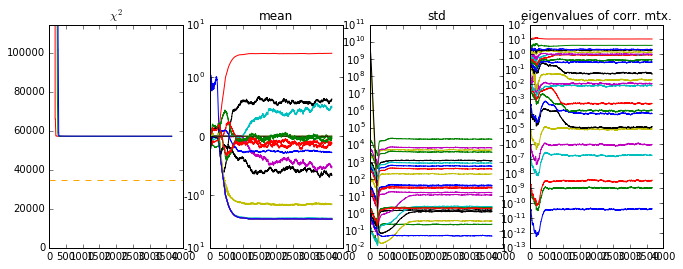

In [12]:
chi2_skip = 0
plt.subplot(141)
plt.plot(np.arange(len(prob))[chi2_skip:],
         -2*1.3**2*np.amax(prob[chi2_skip:],axis=1), color="red")
plt.plot(np.arange(len(prob))[chi2_skip:],
         -2*1.3**2*np.mean(prob[chi2_skip:],axis=1), color="green")
plt.plot(np.arange(len(prob))[chi2_skip:],
         -2*1.3**2*np.amin(prob[chi2_skip:],axis=1), color="blue")
plt.axhline(F.dof(), color="orange", linestyle="--")

#print np.amax(prob[-1]), np.mean(prob[-1]), np.amin(prob[-1])
plt.ylim(0,2*np.amax(-2*1.3**2*np.amin(prob[-20:],axis=1)))

plt.title("$\chi^2$")
for (i,p) in enumerate(F.parameters):
    e = F.best_errors[p]
    plt.subplot(142)
    plt.title("mean")
    plt.plot(np.mean(offsets[...,i]/np.std(offsets[...,i]),axis=1))
    plt.subplot(143)
    plt.title("std")
    plt.semilogy(np.std(offsets[...,i]/e,axis=1))
plt.subplot(142)
plt.yscale('symlog',linthreshy=1)
eigvals = []
for j in range(offsets.shape[0]):
    s = np.array([F.best_errors[p]**(-1) for p in F.parameters])
    vals, vecs = scipy.linalg.eigh(np.corrcoef(offsets[j].T))
    eigvals.append(vals)
eigvals = np.array(eigvals)
for v in eigvals.T:
    plt.subplot(144)
    plt.title("eigenvalues of corr. mtx.")
    plt.semilogy(v)
plt.gcf().set_size_inches(11,4)
plt.savefig(os.path.join(job_dir,"progress.pdf"))

asini_i 0.986099335784
pb_i 0.984933010342
eps1_i 0.980986127169
eps2_i 0.995546573873
tasc_i 0.994489375156
acosi_i 0.979313152598
q_i 0.966386771208
asini_o 0.986818931232
pb_o 0.98449263679
eps1_o 0.984855049052
eps2_o 0.984336190369
tasc_o 0.984718072762
acosi_o 0.971834141929
delta_lan 1.0514740015
delta 0.985096137484
dgamma 1.02605475248
dbeta 0.968574890956
d_RAJ 11.90533759
d_DECJ 14.095776924
d_PMRA 3.93309283808e-11
d_PMDEC 1.2904455068e-10
d_PX 0.0473937721067
j_AO1440 1.07860079215
j_GBT1500 1.06070794324


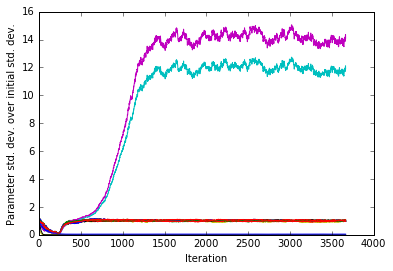

In [13]:
for (i,p) in enumerate(F.parameters):
    plt.plot(np.std(offsets[...,i],axis=1)/np.std(offsets[0,:,i]))
    print p, np.std(offsets[-1,:,i])/np.std(offsets[0,:,i])
#plt.gca().set_yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Parameter std. dev. over initial std. dev.")
plt.savefig("std-growth.pdf")

In [14]:
if full_offsets.shape[1]>1:
    pm = 'acosi_i'
    k = F.parameters.index(pm)
    for i in range(full_offsets.shape[1]):
        plt.semilogy([np.std(full_offsets[j,i,...,k])/F.best_errors[pm] for j in range(len(full_offsets))])
    plt.title("Evolution of std(%s) for different temperatures" % pm) 
    plt.xlabel("Step")
    plt.ylabel("std divided by best_error")

In [15]:
if full_offsets.shape[1]>1:
    for i in range(0,full_offsets.shape[1],5):
        pbs = full_prob[-1,i,... ]
        plt.hist(pbs-np.mean(pbs),histtype='step',label=str(i))
    plt.title("Distribution of log probablity for various temperatures") 
    plt.xlabel("log probability")
    plt.legend(loc="best")

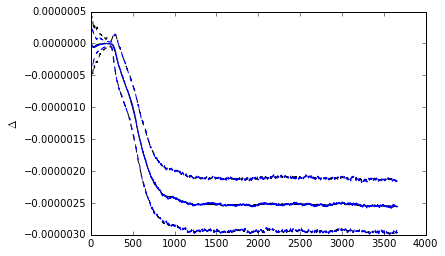

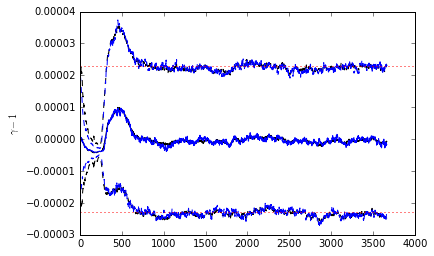

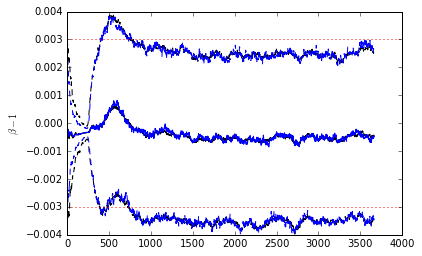

In [16]:
prior_limits = {'delta': 6e-3, 'dgamma':2.3e-5, 'dbeta':3e-3, 'lan':np.pi }
labels = {'delta': r"$\Delta$", 'dgamma': r"$\gamma-1$", 'dbeta': r"$\beta-1$",
          'q_i': r"$q_i$", "acosi_i": r"$(a\cos i)_i$", 'tzrmjd':r"$t_0$", 'f0':r"$f_0$",
          'lan':r"$\Omega$"}
skip = 0
for p in ['delta','dgamma','dbeta','lan']:
    if p not in F.parameters:
        continue
    plt.figure()
    i = F.parameters.index(p)
    ms = np.mean(offsets[skip:,...,i],axis=-1)+F.best_parameters[p]
    ss = np.std(offsets[skip:,...,i],axis=-1)
    plt.plot(ms,color="k")
    plt.plot(ms+ss,color="k",linestyle="--")
    plt.plot(ms-ss,color="k",linestyle="--")
    #if p=='delta':
    #    plt.gca().set_yscale("symlog",linthreshy=1e-6)
    q1, med, q3 = [], [], []
    for j in range(skip,offsets.shape[0]):
        q1.append(scipy.stats.scoreatpercentile(offsets[j,:,i],100*scipy.stats.norm.cdf(-1))+F.best_parameters[p])
        med.append(np.median(offsets[j,:,i])+F.best_parameters[p])
        q3.append(scipy.stats.scoreatpercentile(offsets[j,:,i],100*scipy.stats.norm.cdf(1))+F.best_parameters[p])
    plt.plot(med,color="b")
    plt.plot(q1,color="b",linestyle="--")
    plt.plot(q3,color="b",linestyle="--")
    plt.ylabel(labels[p])
    ny,xy = plt.gca().get_ylim()
    plt.axhline(prior_limits[p],linestyle=":",color="red")
    plt.axhline(-prior_limits[p],linestyle=":",color="red")
    plt.ylim(ny,xy)
    plt.savefig(os.path.join(job_dir,"%s-convergence.pdf" % p))

In [17]:
print "best:", np.amax(full_prob)
print "chi2:", -2*F.efac**2*np.amax(full_prob), "reduced chi2:", -2*F.efac**2*np.amax(full_prob)/len(F.mjds)
print "reduced chi2 with efac:", -2*np.amax(full_prob)/len(F.mjds)
print "iteration:", np.argmax(full_prob)//(full_prob.shape[1]*full_prob.shape[2]), "of", full_prob.shape[0]
if full_offsets.shape[1]>1:
    print "temperature:", (np.argmax(full_prob)//full_prob.shape[2])%full_prob.shape[1], "of", full_prob.shape[1]

best_offset = offsets.reshape((-1,offsets.shape[-1]))[np.argmax(prob.reshape((-1,)))]
params = np.array([np.float128(F.best_parameters[p]) for p in F.parameters])
best_so_far = params+best_offset
np.save(os.path.join(job_dir,"best_so_far.npy"),best_so_far)

best: -16898.6943531
chi2: 33797.3887062 reduced chi2: 0.977650815917
reduced chi2 with efac: 0.977650815917
iteration: 955 of 3665


In [18]:
n_cores = 95
n_walkers = full_offsets.shape[-2]

#print F.parameters[:-7]

# Default: stick to one temperature, don't change the number of walkers
new_walkers = full_offsets[-1,:,:]

# Ditch jumps
#new_walkers = new_walkers[...,:-7]

# multiply the number of walkers by 
#n=2
#new_walkers = full_offsets[-n*20::20,0].reshape((1,-1,offsets.shape[-1]))

# Go up to many temperatures
#nT = 40
#new_walkers = full_offsets[-nT*20::20,0,:]

# Suppy random values for three new parameters
#new_walkers = np.random.randn(1,n_walkers,27)*1e-4
#new_walkers[:,:,:24] = full_offsets[-1,:,:n_walkers]

# Trim excess walkers
#new_walkers = new_walkers[:,:new_walkers.shape[1]*95//96,:]

# Move to center at zero
new_walkers -= np.mean(new_walkers,axis=1)[:,None,:]

# Trim extra jumps
#new_walkers = new_walkers[...,:22]

# Add new jump(s)
#add_jumps = 1
#new_walkers_tmp = np.zeros((new_walkers.shape[0],new_walkers.shape[1],new_walkers.shape[2]+add_jumps), dtype=new_walkers.dtype)
#new_walkers_tmp[:,:,:-add_jumps] = new_walkers
#new_walkers_tmp[:,:,-add_jumps:] = 1e-6*np.random.randn(new_walkers.shape[0],new_walkers.shape[1],add_jumps)
#new_walkers = new_walkers_tmp

# Rearrange parameters
if True:
    if False:
        d = dict(files="0337+17-scott-2014-01-22",
                         parfile="0337_tempo2_px_optical.par",
                         tzrmjd_middle='auto',
                         fit_pos=True,
                         fit_pm=False,
                         fit_px=False,
                         t2_astrometry=True,
                         kopeikin=False,
                         priors=('dbeta','dgammma'),
                         ppn_mode='heavysimple')
    else:
        d = pickle.load(open("fitter_params.pickle"))
    F2 = threebody.Fitter(**d)
    new_walkers_old = new_walkers
    new_walkers = np.random.randn(new_walkers.shape[0],
                                  new_walkers.shape[1],
                                  len(F2.parameters))
    for i,p in enumerate(F2.parameters):
        if p in F.parameters:
            new_walkers[...,i]=new_walkers_old[...,F.parameters.index(p)]
        elif p=='dbeta':
            scale = 3e-3
            new_walkers[...,i]=scale*np.random.randn(
                                    new_walkers.shape[0],
                                    new_walkers.shape[1])
        elif p=='dgamma':
            scale = 2.3e-5
            new_walkers[...,i]=scale*np.random.randn(
                                    new_walkers.shape[0],
                                    new_walkers.shape[1])
        elif p=='delta':
            scale = 1e-6
            new_walkers[...,i]=scale*np.random.randn(
                                    new_walkers.shape[0],
                                    new_walkers.shape[1])
        else:
            print "Don't know how to scale parameter %s" % p

# Scale by
#sf = 10
#new_walkers = (new_walkers-np.mean(new_walkers,axis=0))*sf+np.mean(new_walkers,axis=0)

print new_walkers.shape
np.save(os.path.join(job_dir,"new_walkers.npy"),new_walkers)

(1, 760, 24)


In [24]:
burnin = -600
thin = 10
offs = offsets[burnin::thin].reshape((-1,offsets.shape[-1]))
offs.shape

(45600, 24)

0.722958802574 0.0390063667287


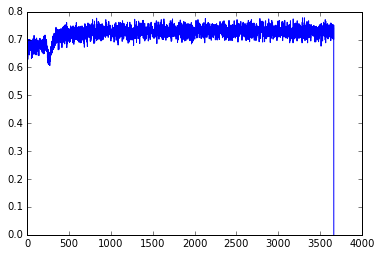

In [20]:
same = []
for i in range(len(offsets)-1):
    same.append(np.sum(np.all(offsets[i]==offsets[i+1],axis=-1))/float(offsets.shape[1]))
plt.plot(same)
print np.mean(same), np.mean(same)**thin

(2785400,)


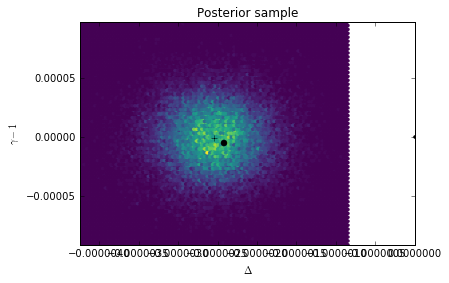

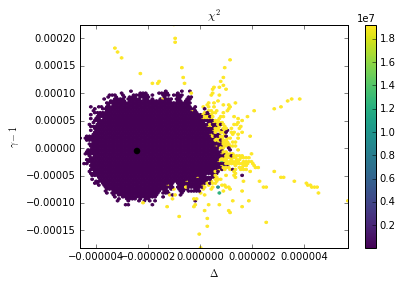

In [21]:
efac = 1.3
l1 = 'delta'
l2 = 'dgamma'
#l1 = 'q_i'
#l2 = 'acosi_i'
#l1 = 'tzrmjd'
#l2 = 'f0'

plt.hexbin(offs[:,F.parameters.index(l1)]+F.best_parameters[l1], 
           offs[:,F.parameters.index(l2)]+F.best_parameters[l2])
plt.xlabel(labels[l1])
plt.ylabel(labels[l2])
plt.plot([np.mean(offs[:,F.parameters.index(l1)])+F.best_parameters[l1]],
         [np.mean(offs[:,F.parameters.index(l2)])+F.best_parameters[l2]],
         "k+")
plt.plot([best_offset[F.parameters.index(l1)]+F.best_parameters[l1]],
         [best_offset[F.parameters.index(l2)]+F.best_parameters[l2]],
         "ko")
plt.plot([F.best_parameters[l1]],
         [F.best_parameters[l2]],
         "k.")
plt.title("Posterior sample")
plt.savefig(os.path.join(job_dir,"posterior.pdf"))


plt.figure() # FIXME: I think the high-temperature probabilities have been 
# rescaled by the temperature factor, but it'd be nice to show their information
vals = -2*efac**2*full_prob[:,0].reshape(-1)
print vals.shape
plt.hexbin(full_offsets[:,0,...,F.parameters.index(l1)].reshape(-1)+F.best_parameters[l1], 
           full_offsets[:,0,...,F.parameters.index(l2)].reshape(-1)+F.best_parameters[l2],
           C=vals, vmax=scipy.stats.scoreatpercentile(vals,95.),
           reduce_C_function = np.amin)
plt.plot([best_offset[F.parameters.index(l1)]+F.best_parameters[l1]],
         [best_offset[F.parameters.index(l2)]+F.best_parameters[l2]],
         "ko")
plt.xlabel(labels[l1])
plt.ylabel(labels[l2])
plt.colorbar()
plt.title("$\chi^2$")
plt.savefig(os.path.join(job_dir,"log-prob.pdf"))

In [22]:
l1 = 'tzrmjd'
l2 = 'f0'

if l1 in F.parameters and l2 in F.parameters:
    xs = offs[:,F.parameters.index(l1)]+F.best_parameters[l1] 
    ys = offs[:,F.parameters.index(l2)]+F.best_parameters[l2]
    stk = np.vstack((xs,ys))
    stk -= np.mean(stk,axis=1)[:,None]
    #vals, vecs = scipy.linalg.eigh(np.corrcoef(stk))
    #print vals
    #xts, yts = np.dot(vecs,stk)
    xts, yts = stk
    yts = yts - np.mean(yts/xts)*xts
    plt.hexbin(xts,yts)
    plt.xlabel(labels[l1]+" minus mean")
    plt.ylabel(labels[l2]+" modified")


delta -2.5(4)e-6
dgamma 0(2)e-5
dbeta 0(3)e-3


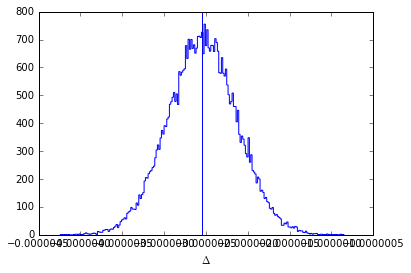

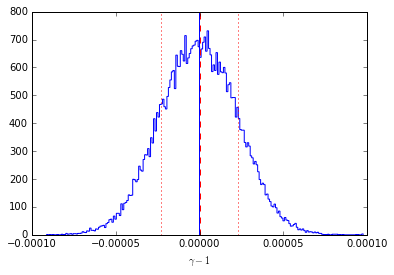

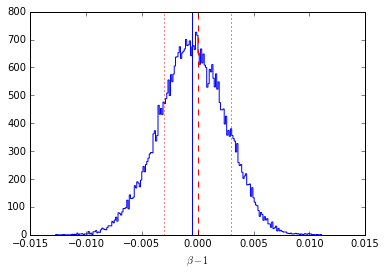

In [25]:
for p in ['delta','dgamma','dbeta','lan']:
    if p not in F.parameters:
        continue
    plt.figure()
    plt.hist(offs[:,F.parameters.index(p)]+F.best_parameters[p],bins=int(np.sqrt(len(offs))), histtype='step')
    plt.axvline(np.mean(offs[:,F.parameters.index(p)])+F.best_parameters[p],color='blue')
    plt.xlabel(labels[p])
    
    nx,xx = plt.gca().get_xlim()
    plt.axvline(prior_limits[p],linestyle=":",color="red")
    plt.axvline(-prior_limits[p],linestyle=":",color="red")
    plt.axvline(0,linestyle="--",color="red")
    plt.xlim(nx,xx)
    
    print p, threebody.fmt(np.mean(offs[:,F.parameters.index(p)]
                                        +F.best_parameters[p]),
                           np.std(offs[:,F.parameters.index(p)]))



In [26]:
stds = np.std(offs,axis=0)
if False:
    vals, vecs = scipy.linalg.eigh(np.corrcoef(offs.T))
    sv = vecs[:,-1]*stds
    ssv = sv/np.array([F.best_errors[p] for p in F.parameters])
    print "This combination of offsets produces negligible change in value:"
    print "%15s\tamount\t\tamount over best_error" % "parameter"

    for (vv,v,p) in sorted(zip(ssv,sv,F.parameters)):
        print "%15s\t%.4g\t%.4g" % (p,v,vv)


In [27]:
params = F.best_parameters.copy()
params0 = F.best_parameters.copy()
for (i,p) in enumerate(F.parameters):
    params0[p] = best_so_far[i]
    params[p] = best_so_far[i]
    params[p] += vecs[i,-1]*stds[i]
r = F.residuals(params)
r0 = F.residuals(params0)

33729.2893154 33742.8193363 34570


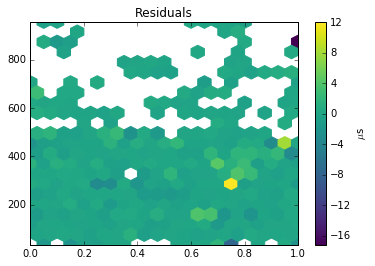

In [28]:
if False:
    plt.hexbin(
        ((F.mjds-F.base_mjd-F.best_parameters['tasc_i'])/F.best_parameters['pb_i'])%1, 
        F.mjds,
        C=(r-r0)/F.best_parameters['f0']*1e6, gridsize=20)
    plt.title("Deviations with minimal effect")
else:
    plt.hexbin(
        ((F.mjds-F.base_mjd-F.best_parameters['tasc_i'])/F.best_parameters['pb_i'])%1, 
        F.mjds,
        C=r0/F.best_parameters['f0']*1e6, gridsize=20)
    plt.title("Residuals")
plt.colorbar().set_label(r"$\mu$s")
print np.sum((r0/F.phase_uncerts)**2), np.sum((r/F.phase_uncerts)**2), len(F.mjds)
plt.savefig(os.path.join(job_dir,"change.pdf"))

In [29]:
for i,p in enumerate(F.parameters):
    v = F.best_parameters[p] + np.mean(offs[:,i])
    e = np.std(offs[:,i])
    print p, threebody.fmt(v,e)

asini_i 1.2175236(5)e0
pb_i 1.6293887(13)e0
eps1_i 6.897(4)e-4
eps2_i -9.139(3)e-5
tasc_i 4.0771623(12)e-1
acosi_i 1.4911(4)e0
q_i 1.37469(13)e-1
asini_o 7.467255(3)e1
pb_o 3.272560(2)e2
eps1_o 3.518560(11)e-2
eps2_o -3.4643(4)e-3
tasc_o 3.139343(2)e2
acosi_o 9.148(3)e1
delta_lan 1(5)e-6
delta -2.5(4)e-6
dgamma 0(2)e-5
dbeta 0(3)e-3
d_RAJ -5(3)e-8
d_DECJ 2.9(12)e-7
d_PMRA -1.1(4)e-10
d_PMDEC 5.0(13)e-10
d_PX 1.6(5)e-1
j_AO1440 -5.5109(8)e-4
j_GBT1500 -5.3765(8)e-4


In [30]:
C = np.corrcoef(offs.T)
for (i,p) in enumerate(F.parameters):
    for (j,q) in enumerate(F.parameters):
        if j<=i:
            continue
        if abs(C[i,j])>0.8:
            print p, q, C[i,j]
    print

asini_i pb_i 0.998642643668
asini_i eps1_i -0.99747326939
asini_i eps2_i 0.809803383253
asini_i tasc_i 0.994018229905
asini_i asini_o 0.991195513382
asini_i pb_o 0.998625516432
asini_i eps1_o 0.998672935202
asini_i eps2_o 0.998648627611
asini_i tasc_o 0.998607229244
asini_i delta 0.998656328443

pb_i eps1_i -0.998878247763
pb_i eps2_i 0.805724075893
pb_i tasc_i 0.995141622578
pb_i asini_o 0.993556806092
pb_i pb_o 0.999934075312
pb_i eps1_o 0.999861862344
pb_i eps2_o 0.999913528457
pb_i tasc_o 0.999925048643
pb_i delta 0.999971398056

eps1_i eps2_i -0.80594316507
eps1_i tasc_i -0.989869463743
eps1_i asini_o -0.992604777299
eps1_i pb_o -0.998845970647
eps1_i eps1_o -0.998790374482
eps1_i eps2_o -0.99881827065
eps1_i tasc_o -0.998836123487
eps1_i delta -0.998869427473

eps2_i tasc_i 0.801063811418
eps2_i pb_o 0.805774501856
eps2_i eps1_o 0.805824717502
eps2_i eps2_o 0.805850073419
eps2_i tasc_o 0.805792543229
eps2_i delta 0.805736481048

tasc_i asini_o 0.988138543276
tasc_i pb_o 0.9947136

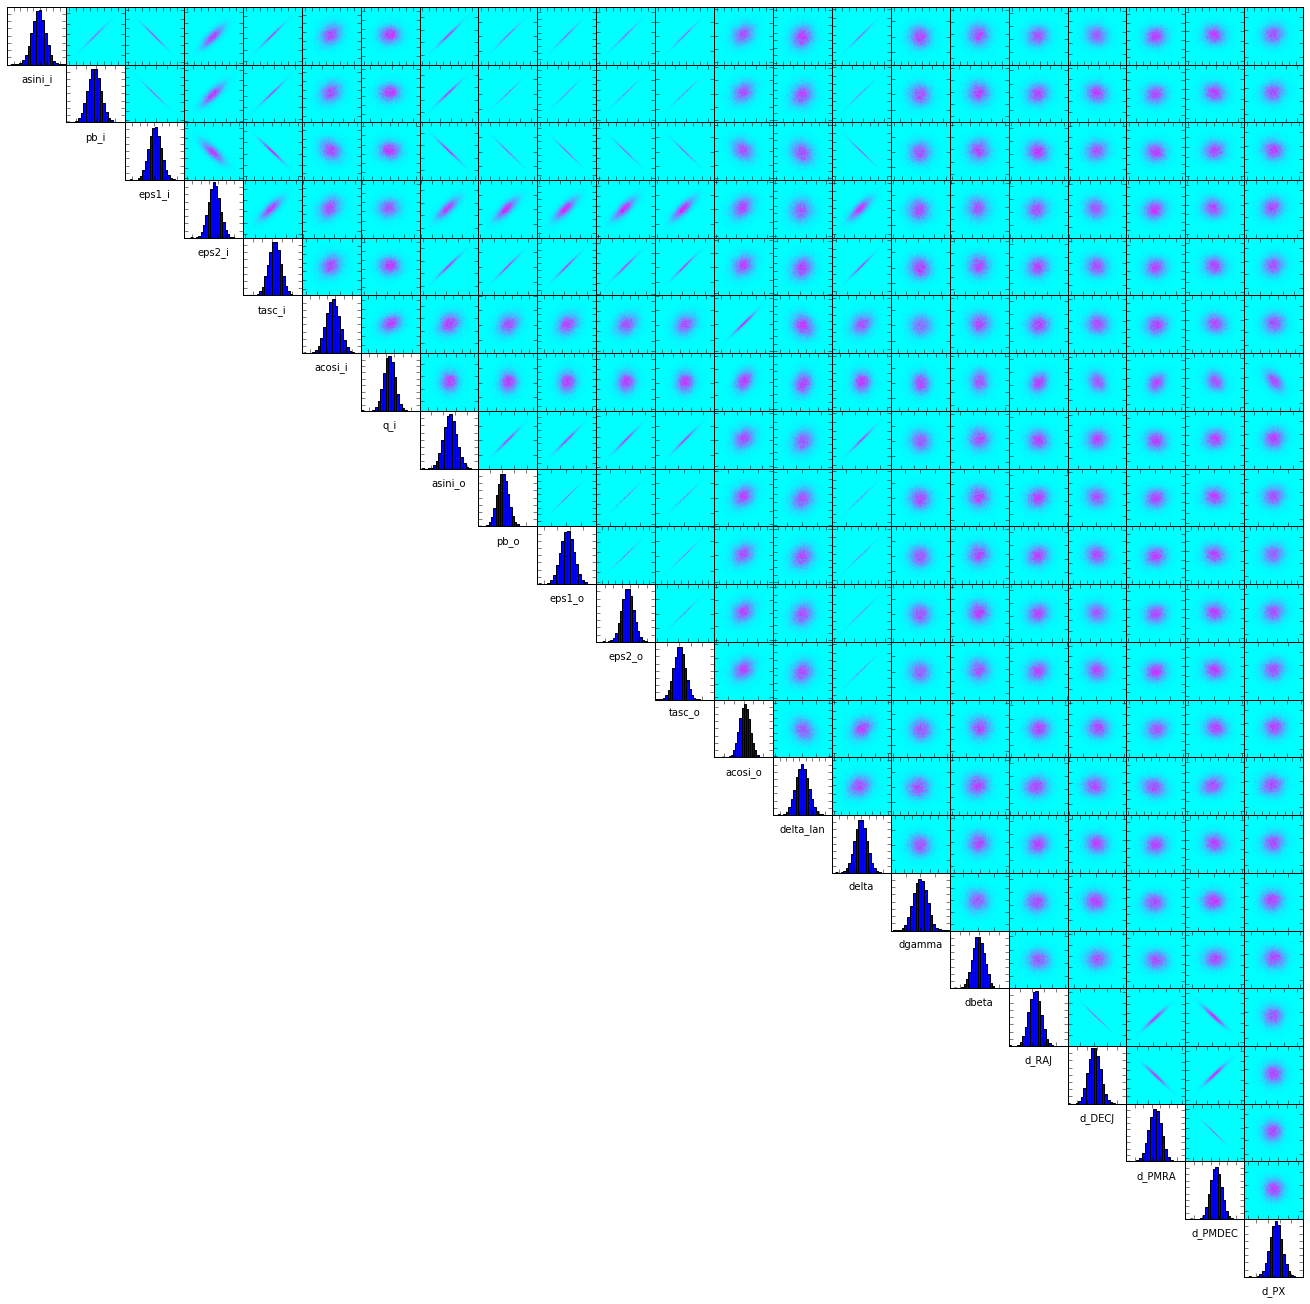

In [31]:
plt.cool()
def covariance_plot(parameters):
    for (i,p1) in enumerate(parameters):
        v1 = offs[:,F.parameters.index(p1)]
        for (j,p2) in enumerate(parameters):
            if j<i:
                continue
            plt.subplot(len(parameters),len(parameters),i*len(parameters)+j+1)
            if j==i:
                plt.hist(v1,bins=20)
                plt.xlabel(p1)
            else:
                v2 = offs[:,F.parameters.index(p2)]
                plt.hexbin(v1,v2,rasterized=True)
            plt.gca().set_xticklabels([])
            plt.gca().set_yticklabels([])
    plt.subplots_adjust(hspace=0,wspace=0,left=0,right=1,top=1,bottom=0.02)
covariance_plot([p for p in F.parameters if not p.startswith("j_")])
plt.gcf().set_size_inches(18,18)
plt.savefig(os.path.join(job_dir,"all-covariances.pdf"))        

In [32]:
params = {}
for i,p in enumerate(F.parameters):
    params[p] = F.best_parameters[p] + np.mean(offs[:,i])
    params[p] = best_so_far[i]
r = F.residuals(params)

169759486745.0 34570 3964.15156922


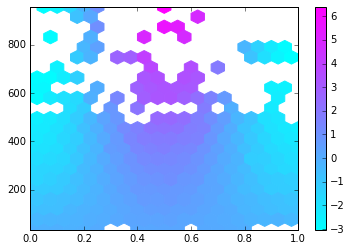

In [33]:
yn, yx = np.amin(F.mjds), np.amax(F.mjds)
plt.hexbin(
    ((F.mjds-F.best_parameters['tasc_i'])/F.best_parameters['pb_i'])%1, 
    F.mjds,
    C=r, 
    extent = (0,1,yn,yx),
    gridsize=20)
plt.colorbar()
print np.sum((r/F.phase_uncerts)**2), len(F.mjds), np.sqrt(np.mean(r**2))/F.best_parameters['f0']*1e6


In [34]:
result = {}
result["base_mjd"] = F.base_mjd
result["tzrmjd_base"] = F.tzrmjd_base
result["file"] = "0337+17-scott-2013-06-06"
result["best_so_far"] = best_so_far
result["parameters"] = F.parameters
result["best_parameters"] = F.best_parameters
result["offset_sample"] = offs
result["mean_value"] = params
result["current_time"] = time.time()
for f in glob("*.py")+glob("*.pyx")+glob("*.hpp"):
    result[f] = os.path.getmtime(f)

np.savez(os.path.join(job_dir,"results.npz"), result)

In [35]:
params

{'acosi_i': 1.4912853701887708539,
 'acosi_o': 91.493339928606905329,
 'asini_i': 1.2175237510083402699,
 'asini_o': 74.672555754957235977,
 'd_DECJ': 3.3327465009908606969e-07,
 'd_PMDEC': 5.4303694361393144533e-10,
 'd_PMRA': -1.2259835369456682319e-10,
 'd_PX': 0.16923521812609295181,
 'd_RAJ': -5.8696520073560975415e-08,
 'dbeta': -0.0012108279374405197458,
 'delta': -2.4246948605511223269e-06,
 'delta_lan': 2.3371851334731322454e-06,
 'dgamma': -5.4331913940710406607e-06,
 'eps1_i': 0.00068961121630381517824,
 'eps1_o': 0.035185627765387591739,
 'eps2_i': -9.138810012878584467e-05,
 'eps2_o': -0.0034641851170267835959,
 'j_AO1440': -0.00055112209152127233328,
 'j_GBT1500': -0.00053766046084117126366,
 'pb_i': 1.6293890501453659056,
 'pb_o': 327.25611739866021244,
 'q_i': 0.13747261531517372903,
 'tasc_i': 0.40771625942018705074,
 'tasc_o': 313.9343871182968794}

In [36]:
kepler_cache = {}
def keplerize(params):
    t = tuple(params)
    if t not in kepler_cache:
        kepler_cache[t] = kepler.kepler_three_body_measurable(*(list(params[:14])+[0,np.zeros(3),np.zeros(3),0]))[0]
    return kepler_cache[t]

In [37]:
def normalize(v):
    return v/np.sqrt(np.dot(v,v))
def angle(v,w):
    return np.arccos(np.dot(normalize(v),normalize(w)))
class Pulsar(object):
    def __init__(self, params, blob, prob):
        for i,p in enumerate(F.parameters):
            setattr(self,p,params[i])
        self.prob = prob
        # FIXME: compute f0, f1, tzrmjd
        d = blob['linear_part']
        self.f0 = d['f0']
        self.f1 = d['f1']
        self.tzrmjd = d['tzrmjd']
        self.coordinates = blob['initial_values']
        self.P = self.f0**(-1)
        self.Pdot = -self.f1*self.f0**(-2)
        self.B = 3.2e19*(self.P*self.Pdot)**(0.5)
        self.Edot = 3.95e31*(self.Pdot/1e-15)*self.P**(-3)
        self.tau = self.P/(2*self.Pdot)/(86400*365.2425)

        x = self.coordinates
    
        self.m_psr = x[6]
        self.m_1 = x[13]
        self.m_2 = x[20]
        
        m_i = x[6]+x[13]
        cm_i = x[:6]*x[6]+x[7:13]*x[13]

        o_vec = normalize(np.cross(x[14:17],x[17:20]))
        i_vec = normalize(np.cross(x[7:10]-x[:3],x[10:13]-x[3:6]))
        j_vec = (x[6]*np.cross(x[:3],x[3:6])+
                 x[13]*np.cross(x[7:10],x[10:13])+
                 x[20]*np.cross(x[14:17],x[17:20]))
        self.i = np.arccos(normalize(j_vec)[2])
        self.i_deg = np.degrees(self.i)   
        self.delta_i = angle(o_vec,i_vec)
        self.delta_i_deg = np.degrees(self.delta_i)
        self.delta_lan_deg = np.degrees(self.delta_lan)
        self.e_i = np.hypot(self.eps1_i,self.eps2_i)
        self.e_o = np.hypot(self.eps1_o,self.eps2_o)
        self.a_i = np.hypot(self.acosi_i,self.asini_i)
        self.a_o = np.hypot(self.acosi_o,self.asini_o)
        self.q_o = self.m_2/(self.m_psr+self.m_1)
        self.m_2_over_m_p = self.m_2/self.m_psr
        self.m_tot = self.m_2+self.m_1+self.m_psr
        self.a_tot_i = self.a_i*(1+1/self.q_i)
        self.a_tot_o = self.a_o*(1+1/self.q_o)
        self.i_i = np.arctan2(self.asini_i,self.acosi_i)
        self.i_i_deg = np.degrees(self.i_i)
        self.i_o = np.arctan2(self.asini_o,self.acosi_o)
        self.i_o_deg = np.degrees(self.i_o)
        self.omega_i = np.arctan2(self.eps1_i, self.eps2_i)
        self.omega_i_deg = np.degrees(self.omega_i)
        self.omega_o = np.arctan2(self.eps1_o, self.eps2_o)
        self.omega_o_deg = np.degrees(self.omega_o)
        self.delta_omega = self.omega_o-self.omega_i
        self.delta_omega_deg = np.degrees(self.delta_omega)
        self.period_ratio = self.pb_i/self.pb_o
        
        # FIXME: double-check and debug this
        self.periastron_advance_i = 6*np.pi/self.pb_i*kepler.G*(self.m_psr+self.m_1)*(self.a_tot_i*kepler.c**2*(1-self.e_i**2))**(-1)
        self.periastron_advance_i_year = self.periastron_advance_i*365.2425
        self.periastron_advance_i_period = 2*np.pi/self.periastron_advance_i_year
        self.periastron_advance_o = 6*np.pi/self.pb_o*kepler.G*(self.m_psr+self.m_2)*(self.a_tot_o*kepler.c**2*(1-self.e_o**2))**(-1)
        self.periastron_advance_o_year = self.periastron_advance_o*365.2425
        self.periastron_advance_o_period = 2*np.pi/self.periastron_advance_o_year

        if 'dbeta' in F.parameters and 'dgamma' in F.parameters:
            self.nordtvedt_parameter = 4*self.dbeta-self.dgamma
            if 'delta' in F.parameters:
                self.nordtvedt_from_delta = -self.delta/0.1

In [38]:
pulsars = []
for orow, bfn, pbr in zip(full_offsets[burnin::thin],
                         full_blobs[burnin::thin],
                         full_prob[burnin::thin]):
    brow = np.load(bfn)
    for j, (o, pb) in enumerate(zip(orow[0],pbr[0])):
        params = [F.best_parameters[p]+o[i] 
                  for (i,p) in enumerate(F.parameters)]
        pulsars.append(Pulsar(params, brow[j],pb))

In [39]:
parameter_means = {}
parameter_errors = {}
for n in dir(pulsars[0]):
    v = getattr(pulsars[0],n)
    if not (isinstance(v,float) or isinstance(v,np.float128) or isinstance(v,np.float64)):
        continue
    vs = [getattr(p,n) for p in pulsars]
    print n, threebody.fmt(np.mean(vs),np.std(vs))
    parameter_means[n] = np.mean(vs)
    parameter_errors[n] = np.std(vs)
np.savez(os.path.join(job_dir,"fitted_parameters.npz"),
         parameter_means=parameter_means,
         parameter_errors=parameter_errors,
         fitter_params=fitter_params)

B 2.218070(16)e8
Edot 3.40369(5)e34
P 2.73258863239(6)e-3
Pdot 1.75823(3)e-20
a_i 1.9250(3)e0
a_o 1.1809(2)e2
a_tot_i 1.5928(3)e1
a_tot_o 5.8861(9)e2
acosi_i 1.4911(4)e0
acosi_o 9.148(3)e1
asini_i 1.2175236(5)e0
asini_o 7.467255(3)e1
d_DECJ 2.9(12)e-7
d_PMDEC 5.0(13)e-10
d_PMRA -1.1(4)e-10
d_PX 1.6(5)e-1
d_RAJ -5(3)e-8
dbeta 0(3)e-3
delta -2.5(4)e-6
delta_i 1.5(2)e-4
delta_i_deg 8.4(13)e-3
delta_lan 1(5)e-6
delta_lan_deg 0(3)e-4
delta_omega -3.359(6)e-2
delta_omega_deg -1.924(3)e0
dgamma 0(2)e-5
e_i 6.958(4)e-4
e_o 3.535573(7)e-2
eps1_i 6.897(4)e-4
eps1_o 3.518560(11)e-2
eps2_i -9.139(3)e-5
eps2_o -3.4643(4)e-3
f0 3.65953363103(8)e2
f1 -2.35466(3)e-15
i 6.8461(14)e-1
i_deg 3.9225(8)e1
i_i 6.8474(13)e-1
i_i_deg 3.9233(8)e1
i_o 6.8460(14)e-1
i_o_deg 3.9224(8)e1
j_AO1440 -5.5109(8)e-4
j_GBT1500 -5.3765(8)e-4
m_1 1.9752(9)e-1
m_2 4.1016(20)e-1
m_2_over_m_p 2.8547(3)e-1
m_psr 1.4368(7)e0
m_tot 2.0445(10)e0
nordtvedt_from_delta 2.5(4)e-5
nordtvedt_parameter 0(12)e-3
omega_i 1.70253(5)e0
omeg

In [40]:
for n in dir(pulsars[0]):
    v = getattr(pulsars[0],n)
    print n, type(v)

B <type 'numpy.float128'>
Edot <type 'numpy.float128'>
P <type 'numpy.float128'>
Pdot <type 'numpy.float128'>
__class__ <type 'type'>
__delattr__ <type 'method-wrapper'>
__dict__ <type 'dict'>
__doc__ <type 'NoneType'>
__format__ <type 'builtin_function_or_method'>
__getattribute__ <type 'method-wrapper'>
__hash__ <type 'method-wrapper'>
__init__ <type 'instancemethod'>
__module__ <type 'str'>
__new__ <type 'builtin_function_or_method'>
__reduce__ <type 'builtin_function_or_method'>
__reduce_ex__ <type 'builtin_function_or_method'>
__repr__ <type 'method-wrapper'>
__setattr__ <type 'method-wrapper'>
__sizeof__ <type 'builtin_function_or_method'>
__str__ <type 'method-wrapper'>
__subclasshook__ <type 'builtin_function_or_method'>
__weakref__ <type 'NoneType'>
a_i <type 'numpy.float128'>
a_o <type 'numpy.float128'>
a_tot_i <type 'numpy.float128'>
a_tot_o <type 'numpy.float128'>
acosi_i <type 'numpy.float128'>
acosi_o <type 'numpy.float128'>
asini_i <type 'numpy.float128'>
asini_o <type '

In [41]:
saved = {}
for i,p in enumerate(pulsars):
    for n in dir(p):
        if n.startswith("_"):
            continue
        v = getattr(p,n)
        if (not isinstance(v,float) 
            and not isinstance(v,np.float128)
            and not isinstance(v,np.float64)):
            continue
        if n not in saved:
            saved[n] = np.zeros(len(pulsars),dtype=np.float128)
        saved[n][i] = v
with open(os.path.join(job_dir,"pulsars.pickle"), "wb") as f:
    pickle.dump(saved, f)

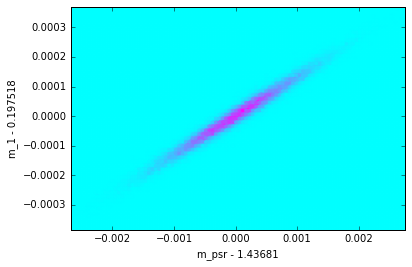

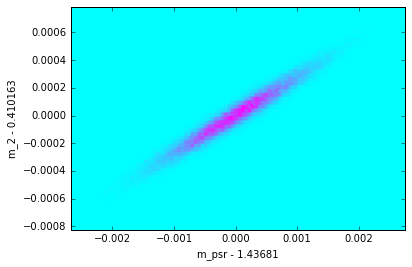

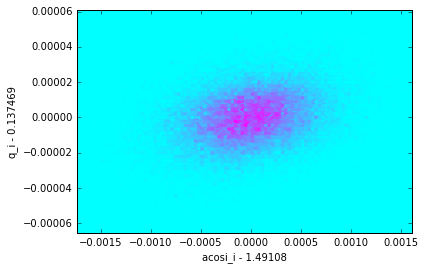

In [42]:
for l1, l2 in [('m_psr','m_1'),
                ('m_psr','m_2'),
                ('acosi_i','q_i'),
                ]:
    plt.figure()
    v1 = np.array([getattr(p,l1) for p in pulsars])
    v2 = np.array([getattr(p,l2) for p in pulsars])
    plt.hexbin(v1-np.mean(v1),v2-np.mean(v2))
    plt.xlabel("%s - %g" % (l1, np.mean(v1)))
    plt.ylabel("%s - %g" % (l2, np.mean(v2)))
    plt.savefig(os.path.join(job_dir,"%s-vs-%s.pdf" % (l1,l2)))

In [43]:
non_classical = ['a_i','a_o','acosi_i','acosi_o','delta_i','delta_lan','i','i_i','i_o','m_1','m_2','m_psr','q_i','q_o']

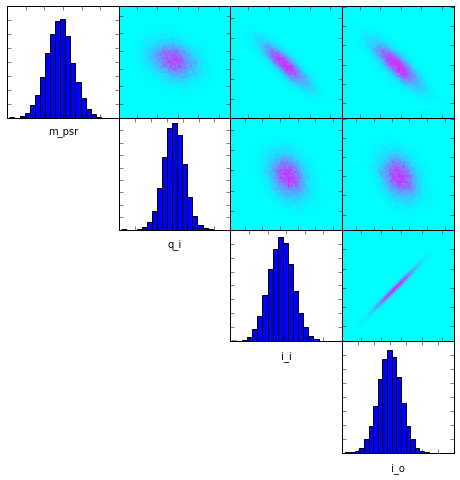

In [44]:
params = ['m_psr','q_i','i_i','i_o']
for (i,p1) in enumerate(params):
    v1 = np.array([getattr(p,p1) for p in pulsars])
    for (j,p2) in enumerate(params):
        if j<i:
            continue
        plt.subplot(len(params),len(params),len(params)*i+j+1)
        if j==i:
            plt.hist(v1,bins=20)
            plt.xlabel(p1)
        else:
            v2 = np.array([getattr(p,p2) for p in pulsars])
            plt.hexbin(v1,v2,rasterized=True)
            #plt.xlabel(p1)
            #plt.ylabel(p2)
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
plt.subplots_adjust(hspace=0,wspace=0)
plt.gcf().set_size_inches(8,8)
plt.savefig("covariances.pdf")

In [45]:
# code by John D. Cook
def farey(x, N):
    a, b = 0, 1
    c, d = 1, 1
    while (b <= N and d <= N):
        mediant = float(a+c)/(b+d)
        if x == mediant:
            if b + d <= N:
                return a+c, b+d
            elif d > b:
                return c, d
            else:
                return a, b
        elif x > mediant:
            a, b = a+c, b+d
        else:
            c, d = a+c, b+d
 
    if (b > N):
        return c, d
    else:
        return a, b

In [46]:
print parameter_means['period_ratio'], parameter_errors['period_ratio']

0.00497894133228 4.58945010727e-10


In [47]:
pr = parameter_means['period_ratio']
for n in [10,100,1000,10000]:
    a,b = farey(pr,n)
    print "%d/%d" % (a,b), abs(pr-a/float(b))/pr

0/1 1.0
0/1 1.0
1/201 0.000766619632504
13/2611 1.21681337957e-06


In [48]:
print 1/pr

200.845909454
